In [40]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt


In [6]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [7]:
dataset = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [87]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features (43800, 8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours, 用前lag_hours来预测后predict_hours
lag_hours = 8
predict_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, lag_hours, predict_hours)
reframed

,var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var7(t-8),var8(t-8),var1(t-7),var2(t-7),...,var7(t+1),var8(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var6(t+2),var7(t+2),var8(t+2)
8,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.140845,0.485294,0.229508,0.636364,0.666667,0.029018,0.037037,0.0
9,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.152918,0.470588,0.229508,0.636364,0.666667,0.034367,0.000000,0.0
10,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.000000,0.0,0.148893,0.470588,0.229508,0.636364,0.666667,0.039716,0.000000,0.0
11,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.000000,0.0,0.164990,0.470588,0.229508,0.618183,0.666667,0.046586,0.000000,0.0
12,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.000000,0.0,0.158954,0.455882,0.229508,0.618183,0.666667,0.053456,0.000000,0.0
13,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634,0.485294,...,0.000000,0.0,0.154930,0.455882,0.229508,0.618183,0.666667,0.060326,0.000000,0.0
14,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0,0.124748,0.485294,...,0.000000,0.0,0.159960,0.455882,0.229508,0.636364,0.666667,0.063385,0.000000,0.0
15,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0,0.120724,0.470588,...,0.000000,0.0,0.164990,0.470588,0.229508,0.654547,0.666667,0.066445,0.000000,0.0
16,0.120724,0.470588,0.213115,0.600000,0.666667,0.020610,0.000000,0.0,0.132797,0.485294,...,0.000000,0.0,0.171026,0.470588,0.229508,0.654547,0.666667,0.071794,0.000000,0.0
17,0.132797,0.485294,0.229508,0.618183,0.666667,0.023669,0.000000,0.0,0.140845,0.485294,...,0.000000,0.0,0.149899,0.470588,0.229508,0.672728,0.666667,0.074853,0.000000,0.0


In [88]:
# split into train and test sets
values = reframed.values
# Use data of one year as training set
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :lag_hours * n_features], train[:, [-n_features * 3, -n_features * 2, -n_features]]
test_X, test_y = test[:, :lag_hours * n_features], test[:, [-n_features * 3, -n_features * 2, -n_features]]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], lag_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 64) 8760 (8760, 3)
(8760, 8, 8) (8760, 3) (35030, 8, 8) (35030, 3)


In [89]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(predict_hours))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35030 samples
Epoch 1/50
 - 6s - loss: 0.0676 - val_loss: 0.0553
Epoch 2/50
 - 6s - loss: 0.0404 - val_loss: 0.0431
Epoch 3/50
 - 6s - loss: 0.0338 - val_loss: 0.0345
Epoch 4/50
 - 6s - loss: 0.0316 - val_loss: 0.0319
Epoch 5/50
 - 6s - loss: 0.0299 - val_loss: 0.0302
Epoch 6/50
 - 6s - loss: 0.0286 - val_loss: 0.0288
Epoch 7/50
 - 6s - loss: 0.0274 - val_loss: 0.0277
Epoch 8/50
 - 6s - loss: 0.0263 - val_loss: 0.0276
Epoch 9/50
 - 6s - loss: 0.0255 - val_loss: 0.0267
Epoch 10/50
 - 6s - loss: 0.0248 - val_loss: 0.0267
Epoch 11/50
 - 6s - loss: 0.0243 - val_loss: 0.0258
Epoch 12/50
 - 6s - loss: 0.0238 - val_loss: 0.0255
Epoch 13/50
 - 6s - loss: 0.0234 - val_loss: 0.0249
Epoch 14/50
 - 6s - loss: 0.0229 - val_loss: 0.0246
Epoch 15/50
 - 6s - loss: 0.0226 - val_loss: 0.0244
Epoch 16/50
 - 6s - loss: 0.0223 - val_loss: 0.0242
Epoch 17/50
 - 6s - loss: 0.0221 - val_loss: 0.0239
Epoch 18/50
 - 6s - loss: 0.0219 - val_loss: 0.0239
Epoch 19/50
 - 6s - loss

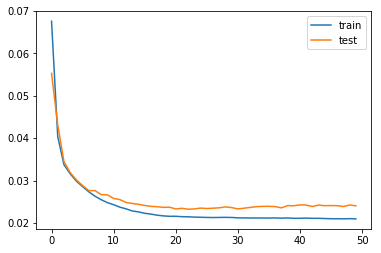

In [90]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [77]:
test_X.shape

(35035, 3, 8)

In [91]:
ypredict = model.predict(test_X)

In [102]:
test_X = test_X.reshape((test_X.shape[0], lag_hours*n_features))
# invert scaling for forecast
inv_ypredict = np.concatenate((ypredict, test_X[:, -5:]), axis=1)
inv_ypredict = scaler.inverse_transform(inv_ypredict)
pm25_predict = inv_ypredict[:, :3]
# invert scaling for actual
test_y = test_y.reshape(len(test_y), predict_hours)
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
pm25_actual = inv_y[:, :3]

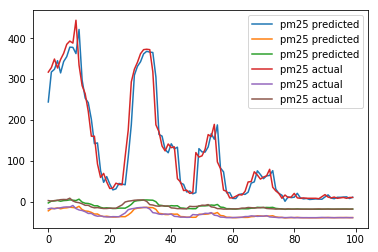

In [101]:
plt.plot(pm25_predict[-100:], '-', label = 'pm25 predicted')
plt.plot(pm25_actual[-100:], '-', label = 'pm25 actual')
plt.legend()
plt.show()

In [103]:
ypredict.shape

(35030, 3)

In [55]:
scaler.inverse_transform(yhat)

ValueError: non-broadcastable output operand with shape (35037,1) doesn't match the broadcast shape (35037,8)

In [49]:
values

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00839101, 0.03703704,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00991199, 0.07407407,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.01143297, 0.11111111,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.27868852, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.25000003, 0.27868852, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)